In [1]:
from functions_for_all_nutrients import *
from vitamin_a_and_zinc_functions import *

In [2]:
# Get absolute path of repo based on relative directory structure, so it should work for all users
import os.path
vivarium_research_lsff_path = os.path.abspath("..")
vivarium_research_lsff_path

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/ihme/homes/ndbs/vivarium_research_lsff'

In [3]:
username = !whoami
username

['ndbs']

In [4]:
# Specify directory with saved GBD data so that it's not necessary to call get_draws on every run.

# Nathaniel has saved some .hdf files in this directory on /share
# You can specify a different directory if you have GBD data saved somewhere else.
# Or if you want to re-pull the data, you can change this to a nonexistent directory.
gbd_data_directory = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data'
gbd_data_filepath = f'{gbd_data_directory}/multmodel_data.hdf'

In [5]:
index_cols=['location_id','sex_id','age_group_id']
age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [6]:
coverage_data_dir = vivarium_research_lsff_path + '/data_prep/outputs/lsff_input_coverage_data.csv'
# # Old version that may not work for all users:
# coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/' \
#     'vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [7]:
location_ids = (list(
                pd.read_csv(coverage_data_dir)
                .location_id
                .unique()))
location_ids

[179, 163, 214, 161, 165, 190, 189, 196, 201, 180, 15, 164, 20]

# VITAMIN A

In [8]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
nutrient = 'vitamin a'
vehicle = 'oil'
effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

In [9]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)b
rr_distribution = lognorm(s=sigma, scale=median)

In [10]:
vitamin_a_baseline_coverage, vitamin_a_counterfactual_coverage = generate_overall_coverage_rates(
                                                     coverage_data_dir,
                                                     nutrient, 
                                                     vehicle,
                                                     coverage_levels,
                                                     years,
                                                     location_ids,
                                                     ['under-5','total population',np.nan])

In [11]:
vitamin_a_baseline_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_baseline_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
vitamin_a_counterfactual_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_counterfactual_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

In [12]:
vitamin_a_rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
vitamin_a_rr_deficiency_nofort.mean(axis=1)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


location_id
179    2.396239
163    2.396239
214    2.396239
161    2.396239
165    2.396239
190    2.396239
189    2.396239
196    2.396239
201    2.396239
180    2.396239
15     2.396239
164    2.396239
20     2.396239
dtype: float64

In [13]:
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_bmgf_25_countries'
try:
    vitamin_a_dalys = pd.read_hdf(gbd_data_filepath, key=vitamin_a_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    vitamin_a_dalys = pull_deficiency_attributable_dalys(rei_id,
                                                  location_ids,
                                                  age_group_ids,
                                                  sex_ids,
                                                  index_cols)
else:
    # Stored data included all 25 locations, so filter to desired locations if try clause succeeded
    vitamin_a_dalys = vitamin_a_dalys.query("location_id in @location_ids")

vitamin_a_dalys.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0       draw_1      draw_10  \
location_id sex_id age_group_id                                          
15          1      2                9.457088    11.813368    13.492116   
                   3              101.910396   106.859675    80.063223   
                   4             5577.054017  1868.354103  1362.434528   
                   5             3028.081708  4251.842675  3323.666190   
            2      2                7.882240    22.328255    13.417963   

                                    draw_100    draw_101     draw_102  \
location_id sex_id age_group_id                                         
15          1      2               25.970686    5.416857    20.635047   
                   3               62.910292   43.429366    96.562874   
                   4             1450.725891  461.326305   899.783374   
                   5             2849.714948  999.270967  2152.584842   
            2      2               13.104034    7.915072    14.872240   

                                    draw_103     draw_104     draw_105  \
location_id sex_id age_group_id                                          
15          1      2                8.109034     9.139613    12.162493   
                   3              113.362231    39.131114    94.133999   
                   4             1561.913132  1679.934920  1976.430759   
                   5             4050.627775  4465.170385  2466.749087   
            2      2               10.548628    11.378221    12.121315   

                                    draw_106  ...     draw_990     draw_991  \
location_id sex_id age_group_id               ...                             
15          1      2                5.717611  ...     5.247302    13.304241   
                   3               85.380409  ...   204.985954    69.879738   
                   4             3030.891691  ...  1502.032190  3123.529021   
                   5             4540.721979  ...  1883.155868  3899.184189   
            2      2                6.249311  ...     7.358625     9.452710   

                                    draw_992     draw_993     draw_994  \
location_id sex_id age_group_id                                          
15          1      2                7.590564    11.710609     4.082534   
                   3              179.953322   128.238259    91.855546   
                   4             2596.552149  3242.790832  3219.452595   
                   5             6064.123832  5757.237755  2768.783968   
            2      2                8.427787    15.503973     4.034775   

                                    draw_995     draw_996     draw_997  \
location_id sex_id age_group_id                                          
15          1      2               11.806004     9.433994    10.303857   
                   3              143.577132    43.692265    59.533151   
                   4              852.056843  1383.056499  3208.586455   
                   5             2401.421180  1244.934809  2568.013194   
            2      2                9.691955     5.469304     8.041087   

                                    draw_998     draw_999  
location_id sex_id age_group_id                            
15          1      2               16.965948     4.676314  
                   3               90.392815    43.156510  
                   4             1633.450576   811.269810  
                   5             4485.584127  1865.974870  
            2      2               10.884324     5.104260  

[5 rows x 1000 columns]

In [14]:
vitamin_a_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    vitamin_a_rr_deficiency_nofort, 
                                    vitamin_a_baseline_effective_coverage)
vitamin_a_paf_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0    draw_1   draw_10  draw_100  \
location_id sex_id age_group_id year                                          
15          1      2            2021  0.78595  0.447022  0.406811  0.340996   
                                2022  0.78595  0.447022  0.406811  0.340996   
                                2023  0.78595  0.447022  0.406811  0.340996   
                                2024  0.78595  0.447022  0.406811  0.340996   
                                2025  0.78595  0.447022  0.406811  0.340996   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id sex_id age_group_id year                                           
15          1      2            2021  0.617978  0.620854  0.149863  0.636347   
                                2022  0.617978  0.620854  0.149863  0.636347   
                                2023  0.617978  0.620854  0.149863  0.636347   
                                2024  0.617978  0.620854  0.149863  0.636347   
                                2025  0.617978  0.620854  0.149863  0.636347   

                                      draw_105  draw_106  ...  draw_990  \
location_id sex_id age_group_id year                      ...             
15          1      2            2021  0.421241  0.759597  ...  0.507946   
                                2022  0.421241  0.759597  ...  0.507946   
                                2023  0.421241  0.759597  ...  0.507946   
                                2024  0.421241  0.759597  ...  0.507946   
                                2025  0.421241  0.759597  ...  0.507946   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id sex_id age_group_id year                                           
15          1      2            2021  0.455066  0.740104  0.785748  0.396677   
                                2022  0.455066  0.740104  0.785748  0.396677   
                                2023  0.455066  0.740104  0.785748  0.396677   
                                2024  0.455066  0.740104  0.785748  0.396677   
                                2025  0.455066  0.740104  0.785748  0.396677   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id sex_id age_group_id year                                           
15          1      2            2021  0.557149   0.64751  0.441514  0.406003   
                                2022  0.557149   0.64751  0.441514  0.406003   
                                2023  0.557149   0.64751  0.441514  0.406003   
                                2024  0.557149   0.64751  0.441514  0.406003   
                                2025  0.557149   0.64751  0.441514  0.406003   

                                      draw_999  
location_id sex_id age_group_id year            
15          1      2            2021  0.393076  
                                2022  0.393076  
                                2023  0.393076  
                                2024  0.393076  
                                2025  0.393076  

[5 rows x 1000 columns]

In [15]:
vitamin_a_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    vitamin_a_paf_deficiency_nofort,
                                    vitamin_a_baseline_effective_coverage,
                                    vitamin_a_counterfactual_effective_coverage)
vitamin_a_pif_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0  draw_1  draw_10  \
location_id sex_id age_group_id year coverage_level                            
15          1      2            2021 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   
                                     0.8                0.0     0.0      0.0   
                                2022 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   

                                                     draw_100  draw_101  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_102  draw_103  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_104  draw_105  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_106  ...  draw_990  \
location_id sex_id age_group_id year coverage_level            ...             
15          1      2            2021 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   
                                     0.8                  0.0  ...       0.0   
                                2022 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   

                                                     draw_991  draw_992  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_993  draw_994  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_995  draw_996  \
location_id sex_id age_group_id year coverage_level                       
15          1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
 

In [16]:
vitamin_a_overall_pifs, vitamin_a_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    vitamin_a_pif_deficiency_nofort,
                                                    vitamin_a_dalys,
                                                    coverage_levels, years)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
vitamin_a_daly_reduction_rates = calculate_rates(vitamin_a_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
vitamin_a_overall_pifs['measure'] = 'pif'
vitamin_a_daly_reduction_counts['measure'] = 'counts_averted'
vitamin_a_daly_reduction_rates['measure'] = 'rates_averted'
vitamin_a_results = pd.concat([vitamin_a_overall_pifs.reset_index(),
                         vitamin_a_daly_reduction_counts.reset_index(),
                         vitamin_a_daly_reduction_rates.reset_index()],
                        ignore_index=True)
vitamin_a_results.to_pickle('results_raw/vitamin_a.pkl')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


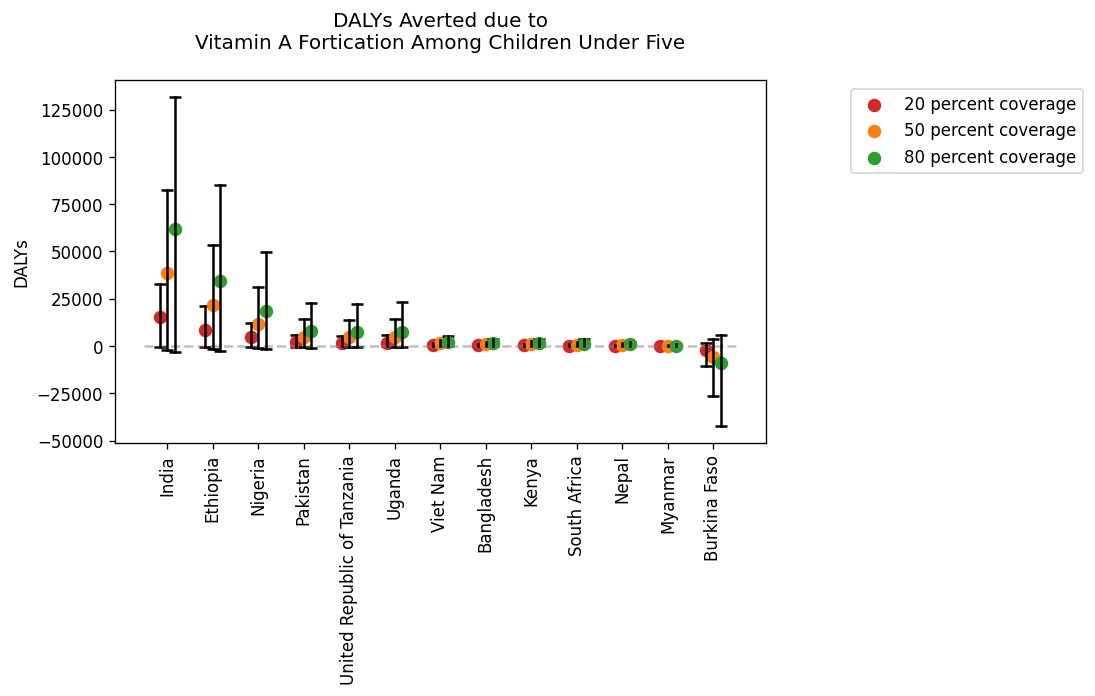

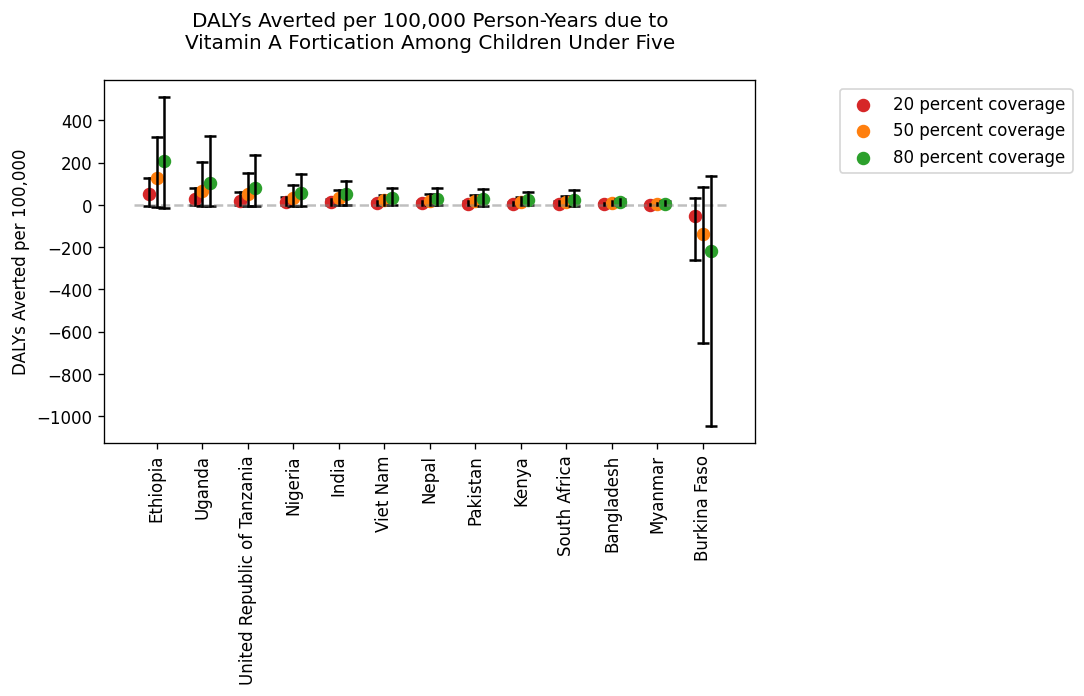

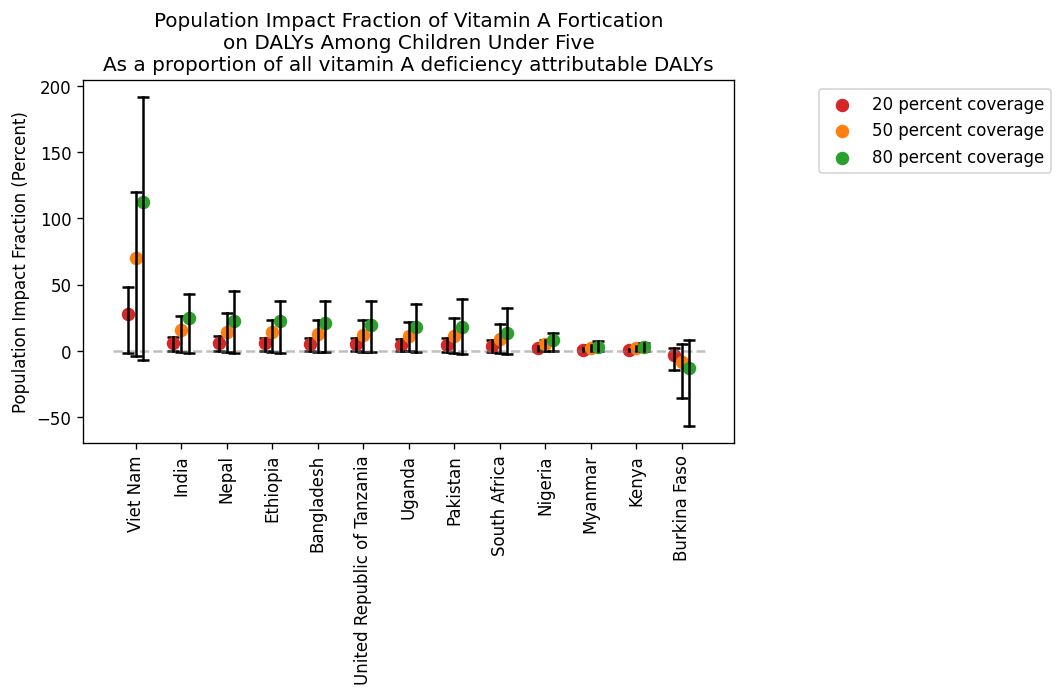

In [19]:
make_dot_plots(vitamin_a_daly_reduction_counts, 'Vitamin A', 'counts', coverage_levels, '', 'vitamin_a_u5_counts_averted')
make_dot_plots(vitamin_a_daly_reduction_rates, 'Vitamin A', 'rates', coverage_levels, '', 'vitamin_a_u5_rates_averted')
make_dot_plots(vitamin_a_overall_pifs, 'Vitamin A', 'pifs', coverage_levels, 
               'As a proportion of all vitamin A deficiency attributable DALYs',
              'vitamin_a_u5_pif')

# ZINC

In [20]:
# ZINC
rei_id = 97
nutrient = 'zinc'
vehicle = 'wheat flour'
effective_fractions = [0,0,0,1]

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [22]:
zinc_baseline_coverage, zinc_counterfactual_coverage = generate_overall_coverage_rates(
                                                     coverage_data_dir,
                                                     nutrient, 
                                                     vehicle,
                                                     coverage_levels,
                                                     years,
                                                     location_ids,
                                                     ['under-5','total population',np.nan])

In [23]:
zinc_rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))
zinc_rr_deficiency_nofort.mean(axis=1)

location_id
179    2.178029
163    2.178029
214    2.178029
161    2.178029
165    2.178029
190    2.178029
189    2.178029
196    2.178029
201    2.178029
180    2.178029
15     2.178029
164    2.178029
20     2.178029
dtype: float64

In [24]:
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_bmgf_25_countries'
try:
    zinc_dalys = pd.read_hdf(gbd_data_filepath, key=zinc_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    zinc_dalys = pull_deficiency_attributable_dalys(rei_id,
                                              location_ids,
                                              age_group_ids,
                                              sex_ids,
                                              index_cols)
else:
    # Stored data included all 25 locations, so filter to desired locations if try clause succeeded
    zinc_dalys = zinc_dalys.query("location_id in @location_ids")

zinc_dalys.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0     draw_1     draw_10  \
location_id sex_id age_group_id                                      
15          1      5             313.163965  18.266017   79.234558   
            2      5             191.677001  12.352737   50.662059   
20          1      5              48.242884   2.459229   19.265943   
            2      5              33.987463   2.445378   12.929698   
161         1      5             296.769109  74.453137  221.348018   

                                   draw_100    draw_101    draw_102  \
location_id sex_id age_group_id                                       
15          1      5             128.724069   27.397756   42.252433   
            2      5              88.065378   16.415385   25.701953   
20          1      5              52.284870   10.616299   10.393659   
            2      5              34.366954    7.370117    5.299798   
161         1      5             351.983373  180.640379  116.430535   

                                  draw_103    draw_104    draw_105  \
location_id sex_id age_group_id                                      
15          1      5             45.034578  168.170188  167.670791   
            2      5             32.398456  214.882244  224.620248   
20          1      5             12.405497   49.169895   64.661551   
            2      5             12.029762   28.076533   52.268909   
161         1      5             89.058635  358.929601  639.977786   

                                   draw_106  ...    draw_990    draw_991  \
location_id sex_id age_group_id              ...                           
15          1      5             189.359412  ...  132.672371  285.220362   
            2      5              59.568140  ...   97.337436  153.330263   
20          1      5              22.958977  ...   72.421762  124.529588   
            2      5              16.943491  ...   36.362487   67.532892   
161         1      5             310.348658  ...  432.487807  463.977633   

                                   draw_992    draw_993    draw_994  \
location_id sex_id age_group_id                                       
15          1      5             102.390704  220.484294  547.323432   
            2      5              70.591128  137.252187  339.566706   
20          1      5              36.856869   57.714761  189.540112   
            2      5              19.427669   29.743642  102.578148   
161         1      5             244.970937  403.311520  721.292922   

                                   draw_995    draw_996    draw_997  \
location_id sex_id age_group_id                                       
15          1      5             387.181049  198.262244   86.842222   
            2      5             216.491836   73.747575   73.569971   
20          1      5             166.677178   53.183620   45.270356   
            2      5              63.898866   28.843567   20.331979   
161         1      5             654.274139  309.811501  251.686322   

                                   draw_998    draw_999  
location_id sex_id age_group_id                          
15          1      5             112.237688  146.724520  
            2      5              90.659169  156.583992  
20          1      5              40.578213   81.721393  
            2      5              23.322774   55.612719  
161         1      5             175.636588  426.660064  

[5 rows x 1000 columns]

In [25]:
zinc_baseline_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_baseline_coverage,
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)
zinc_counterfactual_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_counterfactual_coverage,
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
zinc_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    zinc_rr_deficiency_nofort, 
                                    zinc_baseline_effective_coverage)
zinc_paf_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  \
location_id age_group_id sex_id year                                           
15          2            1      2021  0.345476  0.571001  0.584197  0.603221   
                                2022  0.345476  0.571001  0.584197  0.603221   
                                2023  0.345476  0.571001  0.584197  0.603221   
                                2024  0.345476  0.571001  0.584197  0.603221   
                                2025  0.345476  0.571001  0.584197  0.603221   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id age_group_id sex_id year                                           
15          2            1      2021  0.494235   0.49253  0.645743  0.483019   
                                2022  0.494235   0.49253  0.645743  0.483019   
                                2023  0.494235   0.49253  0.645743  0.483019   
                                2024  0.494235   0.49253  0.645743  0.483019   
                                2025  0.494235   0.49253  0.645743  0.483019   

                                      draw_105  draw_106  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
15          2            1      2021  0.579614  0.378442  ...  0.548122   
                                2022  0.579614  0.378442  ...  0.548122   
                                2023  0.579614  0.378442  ...  0.548122   
                                2024  0.579614  0.378442  ...  0.548122   
                                2025  0.579614  0.378442  ...  0.548122   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
15          2            1      2021  0.568194  0.399642   0.34575  0.587321   
                                2022  0.568194  0.399642   0.34575  0.587321   
                                2023  0.568194  0.399642   0.34575  0.587321   
                                2024  0.568194  0.399642   0.34575  0.587321   
                                2025  0.568194  0.399642   0.34575  0.587321   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id sex_id year                                           
15          2            1      2021  0.526427  0.475794  0.572889  0.584449   
                                2022  0.526427  0.475794  0.572889  0.584449   
                                2023  0.526427  0.475794  0.572889  0.584449   
                                2024  0.526427  0.475794  0.572889  0.584449   
                                2025  0.526427  0.475794  0.572889  0.584449   

                                      draw_999  
location_id age_group_id sex_id year            
15          2            1      2021  0.588412  
                                2022  0.588412  
                                2023  0.588412  
                                2024  0.588412  
                                2025  0.588412  

[5 rows x 1000 columns]

In [27]:
zinc_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    zinc_paf_deficiency_nofort,
                                    zinc_baseline_effective_coverage,
                                    zinc_counterfactual_effective_coverage)
zinc_pif_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0  draw_1  draw_10  \
location_id age_group_id sex_id year coverage_level                            
15          2            1      2021 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   
                                     0.8                0.0     0.0      0.0   
                                2022 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   

                                                     draw_100  draw_101  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_102  draw_103  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_104  draw_105  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_106  ...  draw_990  \
location_id age_group_id sex_id year coverage_level            ...             
15          2            1      2021 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   
                                     0.8                  0.0  ...       0.0   
                                2022 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   

                                                     draw_991  draw_992  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_993  draw_994  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_995  draw_996  \
location_id age_group_id sex_id year coverage_level                       
15          2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
 

In [28]:
zinc_overall_pifs, zinc_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    zinc_pif_deficiency_nofort,
                                                    zinc_dalys,
                                                    coverage_levels, years)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
zinc_daly_reduction_rates = calculate_rates(zinc_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
zinc_overall_pifs['measure'] = 'pif'
zinc_daly_reduction_counts['measure'] = 'counts_averted'
zinc_daly_reduction_rates['measure'] = 'rates_averted'
zinc_results = pd.concat([zinc_overall_pifs.reset_index(),
                         zinc_daly_reduction_counts.reset_index(),
                         zinc_daly_reduction_rates.reset_index()],
                        ignore_index=True)
zinc_results.to_pickle('results_raw/zinc.pkl')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


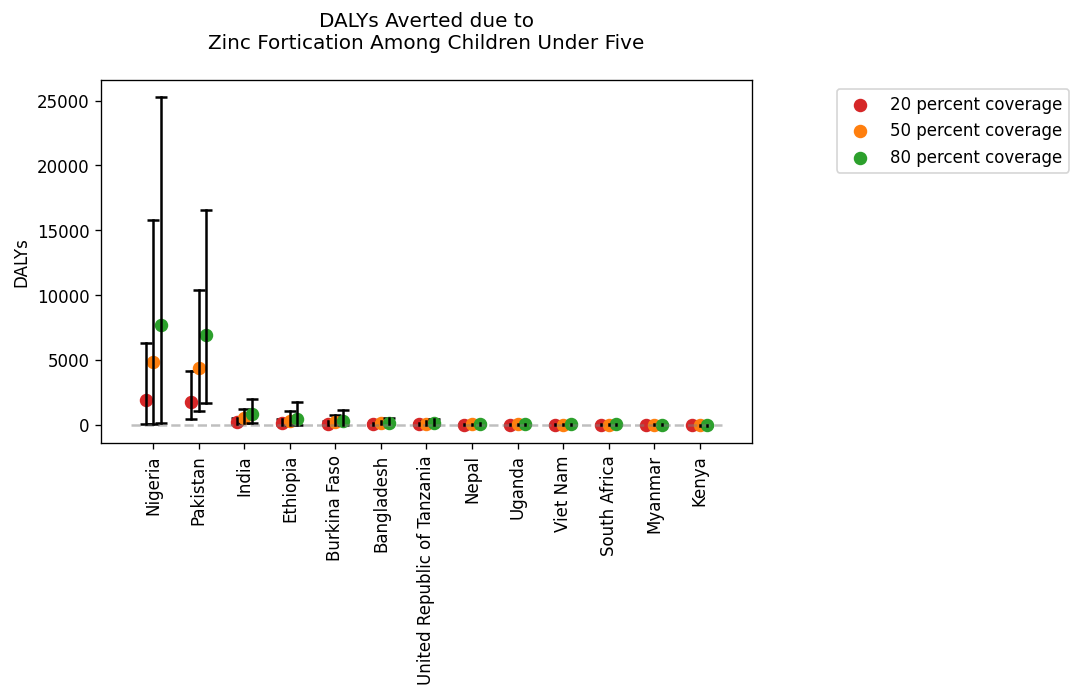

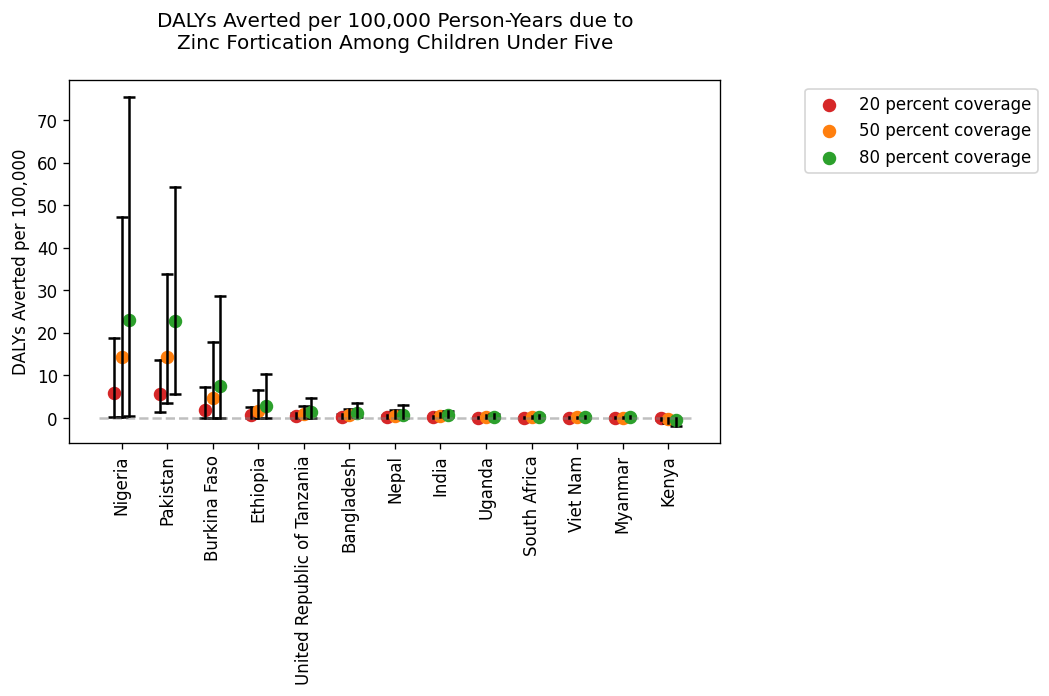

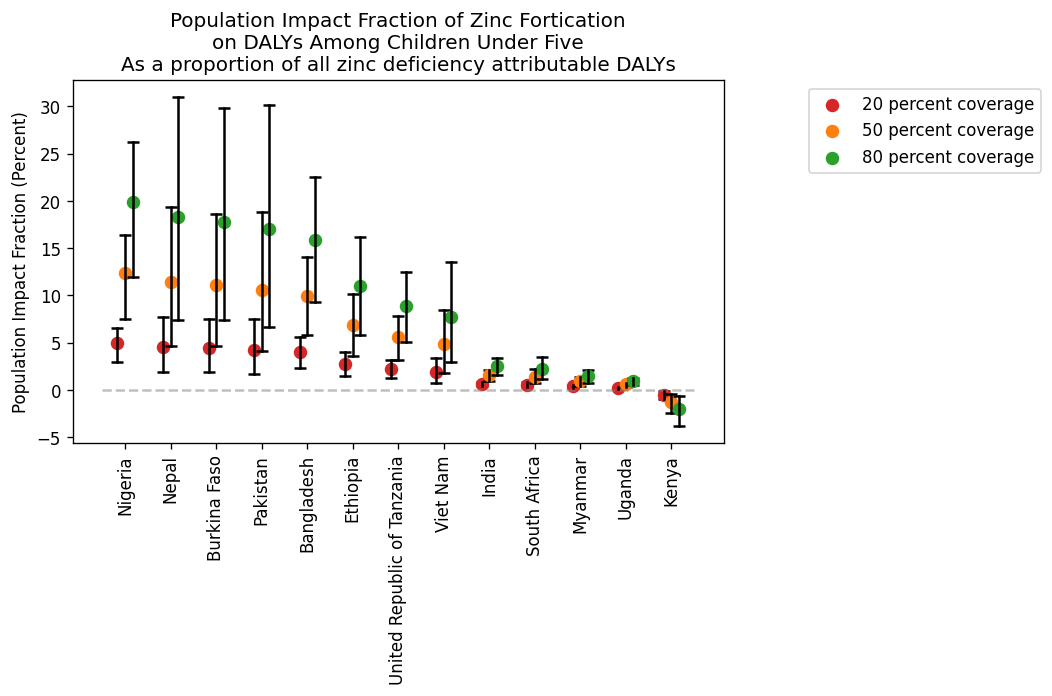

In [31]:
make_dot_plots(zinc_daly_reduction_counts, 'Zinc', 'counts', coverage_levels,"", 'zinc_u5_counts_averted')
make_dot_plots(zinc_daly_reduction_rates, 'Zinc', 'rates', coverage_levels,"",'zinc_u5_rates_averted')
make_dot_plots(zinc_overall_pifs, 'Zinc', 'pifs', coverage_levels,"As a proportion of all zinc deficiency attributable DALYs",
              'zinc_u5_pif')